# Homework 02 - Data from the web

During this homework we had to extract the students information and compute the total number of semesters their spend in the school. As this information is not given as such we had to make some assumptions given here:
- Only the student that attended the 1st and 6th semester of bachelor have been kept. Those are considered to have completed their bachelor.
- As it is possible to finish on the 5th semester (e.g. 1-2-3-4-5-6-5 semester is a viable way to complete a bachelor), we decided to count the total number of semesters spend in the EPFL on people respecting the first point.

The first thing we have done was to analyze the requests on IS-Acadamia using Postman in order to understand how to create the requests needed.
It was found that by modifying the GPS field it was easily possible to perform the extraction.

The work has been separated as follow:
- Creation of a GPS list with section, year and seasons
- Extraction of the infos using those GPS
- Data cleaning
- Filtering of data and visualization of results

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup as bs

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from scipy.stats import mannwhitneyu

## Creation of a list sorted by GPS
Using Postman, we retrieve the url needed to obtain the GPS values for the data sets available on the IS-Academia website.

In [6]:
gps_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=&ww_x_PERIODE_ACAD=null&zz_x_PERIODE_PEDAGO=&ww_x_PERIODE_PEDAGO=null&zz_x_HIVERETE=&ww_x_HIVERETE=null&dummy=ok'

gps_r = requests.get(gps_url)

Then the content of the request is parsed unsing functions of BeautifulSoup and the GPS values are extracted and added into a dataframe with some complementary information namely the section, the year and the academic period related to each dataframe.

In [7]:
gps_html = bs(gps_r.content, "html.parser")

gps_html_ = gps_html.find_all(class_='ww_x_GPS')
gps_list = []
gps_list2 = []
for elem in gps_html_:
    gps_list.append(elem.string.split(','))
    #string s_ of format "loadReport('ww_x_GPS=24065660');return false;" shorten to "24065660" only
    s_ = elem['onclick'].split('=')[1].split("')")[0]
    gps_list2.append(s_)

In [8]:
gps_df = pd.concat((pd.DataFrame(gps_list), pd.DataFrame(gps_list2)), axis=1)
gps_df.columns = ["Section", "Year", "AcPeriod", "GPS"]
gps_df.set_index("GPS", inplace=True)
gps_df = gps_df.ix[1:]

In [9]:
gps_df.head(10) #only head shown for convenience

,Section,Year,AcPeriod
GPS,,,
24065660,Echange IN,2005-2006,Semestre automne
24065672,Echange IN,2005-2006,Semestre printemps
39467937,Echange IN,2006-2007,Semestre automne
39467957,Echange IN,2006-2007,Semestre printemps
71454914,Echange IN,2007-2008,Semestre automne
71454935,Echange IN,2007-2008,Semestre printemps
117663512,Echange IN,2008-2009,Semestre automne
117663545,Echange IN,2008-2009,Semestre printemps
230302571,Echange IN,2009-2010,Semestre automne


## Extracting the infos using GPS and cleaning

## Task 1

To retrieve the desired data, we define the variables years and bachelors to match the columns of the GPS dataframe.

In [10]:
years = range(2007,2016)
years_ = []
for e in years:
    years_.append(" {0}-{1}".format(str(e),str(e+1)))

In [11]:
bachelors = []
for i in range(1,7):
    bachelors.append(" Bachelor semestre {}".format(i))

In [12]:
gps_final = gps_df[gps_df['Section'] == "Informatique"][gps_df['Year'].isin(years_)][gps_df['AcPeriod'].isin(bachelors)]
gps_final.head()

C:\Users\Sylvain\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Section,Year,AcPeriod
GPS,,,
71297531,Informatique,2007-2008,Bachelor semestre 1
71297550,Informatique,2007-2008,Bachelor semestre 2
39494788,Informatique,2007-2008,Bachelor semestre 3
39494823,Informatique,2007-2008,Bachelor semestre 4
19561980,Informatique,2007-2008,Bachelor semestre 5


We create multiple requests to obtain the data from IS-Academia and we store them in dataframes using the read_html function and we index the dataframe by Sciper number since they are unique. Then, we add those dataframes in two lists.
In the simple list, we do not care about the year related to the academic period and in the complete list, we display all the informations. These two lists will be used to merge the dataframes and clean the data.

In [13]:
url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?'
dfs_complete = []
dfs_simple = []
for gps_value in gps_final.index:
    payload = {'ww_x_GPS': gps_value, 'ww_i_reportModel': 133685247, 'ww_i_reportModelXsl' : 133685270}
    req = requests.get(url, params=payload)
    df = pd.read_html(req.content, header=1)[0]
    df.set_index("No Sciper", inplace=True)
    df_complete = df.rename(columns = {'Statut':'Status' + str(gps_final.loc[gps_value].AcPeriod) + ' ' + str(gps_final.loc[gps_value].Year)})
    df_simple = df.rename(columns = {'Statut':'Status' + str(gps_final.loc[gps_value].AcPeriod)})
    dfs_complete.append(df_complete)
    dfs_simple.append(df_simple)

We keep only the students which have an entry in Bachelor semester 1 and Bachelor semester 6 and we use their sciper number as index to easily acces all the students which have completed their bachelor in the complete dataframe

In [14]:
dfBA_simple = dfs_simple[0]
for df in dfs_simple:
    dfBA_simple = dfBA_simple.combine_first(df)

In [15]:
dfBA_complete = dfs_complete[0]
for df in dfs_complete:
    dfBA_complete = dfBA_complete.combine_first(df)

In [16]:
dfBA_simple = dfBA_simple[dfBA_simple['Status Bachelor semestre 1'].notnull()]
dfBA_simple = dfBA_simple[dfBA_simple['Status Bachelor semestre 6'].notnull()]

To have the number of semesters per student, we simply count the values which are not null, for the columns corresponding to the Status for each semester and each year.

In [17]:
dfBA_completetemp = dfBA_complete
dfBA_completetemp = dfBA_completetemp.loc[dfBA_simple.index]
dfBA_completetemp["Nb_Semesters"] = dfBA_complete.ix[:,8:62].notnull().sum(axis=1)

In [18]:
dfBA_completetemp[["Civilité", "Nb_Semesters"]].groupby("Civilité").mean()

,Nb_Semesters
Civilité,
Madame,6.642857
Monsieur,7.103746


It is a good idea to compute the histogram of number of semesters of both gender to get an idea on the distribution.

In [19]:
df_man = dfBA_completetemp[["Civilité", "Nb_Semesters"]][dfBA_completetemp.Civilité == "Monsieur"]

In [20]:
df_woman = dfBA_completetemp[["Civilité", "Nb_Semesters"]][dfBA_completetemp.Civilité == "Madame"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AE9A9B0>]], dtype=object)

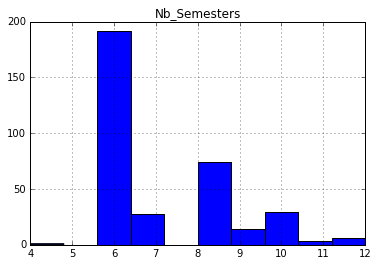

In [21]:
df_man.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B1099B0>]], dtype=object)

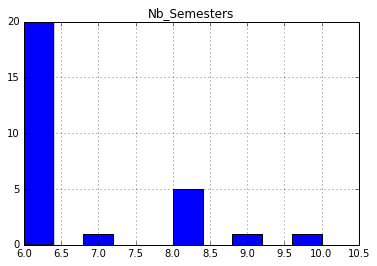

In [22]:
df_woman.hist()

It is clear that the distribution is not normal. As the data is not paired as well we decided to use the Mann-Whitney U-Test (see the slide containing a tree on which statistical tool to choose from the course).

Our null hypothesis H0 is that both average of number of semesters per men and women are from the same distribution.

In [23]:
lst_man = df_man['Nb_Semesters'].tolist()
lst_woman = df_woman['Nb_Semesters'].tolist()

In [24]:
mannwhitneyu(lst_man, lst_woman, alternative='two-sided')

MannwhitneyuResult(statistic=5653.5, pvalue=0.10915425641470894)

In [25]:
mannwhitneyu([6.642857], [7.103746], alternative='two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=1.0)

In [26]:
len(lst_man) # Number of entries for male

347

In [27]:
len(lst_woman) # Number of entries for female

28

This p-value does not allow us to reject the null hypthosis. It is also to be noticed that the skew in the number of samples per gender might affect the quality of the result.

## Task 2

We have used a similar approach for the master and bachelor students, thus we extract the GPS values related to the masters from the GPS dataframe created above.

In [28]:
masters = []
for i in range(1,5):
    masters.append(" Master semestre {}".format(i))

In [29]:
gps_final = gps_df[gps_df['Section'] == "Informatique"][gps_df['Year'].isin(years_)][gps_df['AcPeriod'].isin(masters)]
gps_final.head()

C:\Users\Sylvain\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Section,Year,AcPeriod
GPS,,,
71450699,Informatique,2007-2008,Master semestre 1
71450725,Informatique,2007-2008,Master semestre 2
39495424,Informatique,2007-2008,Master semestre 3
109592281,Informatique,2008-2009,Master semestre 1
109592309,Informatique,2008-2009,Master semestre 2


In [30]:
dfs_complete = []
dfs_simple = []
for gps_value in gps_final.index:
    payload = {'ww_x_GPS': gps_value, 'ww_i_reportModel': 133685247, 'ww_i_reportModelXsl' : 133685270}
    req = requests.get(url, params=payload)
    df = pd.read_html(req.content, header=1)[0]
    df.set_index("No Sciper", inplace=True)
    df_complete = df.rename(columns = {'Statut':'Status' + str(gps_final.loc[gps_value].AcPeriod) + ' ' + str(gps_final.loc[gps_value].Year)})
    df_simple = df.rename(columns = {'Statut':'Status' + str(gps_final.loc[gps_value].AcPeriod)})
    dfs_complete.append(df_complete)
    dfs_simple.append(df_simple)

### Assumptions
- Assumption 1 : A student must at least do the Master Semester 1 and Master Semester 2 to obtain his degree. Some students which have done their bachelor in 7 semesters have begun their master in semseter 2, so it is necessary to check if both semseters have been completed.
- Assumption 2 : If a student does a specialisation or a minor then he must completed at least 3 semesters to obtain his masters degree.

Thus, for the simple dataframe, we have kept only the students which had an entry for our assumptions and we discard the rest.

In [31]:
dfMA_simple = dfs_simple[0]
for df in dfs_simple:
    dfMA_simple = dfMA_simple.combine_first(df)

In [32]:
dfMA_complete = dfs_complete[0]
for df in dfs_complete:
    dfMA_complete = dfMA_complete.combine_first(df)

In [34]:
# Assumption 1
dfMA_simple1 = dfMA_simple[dfMA_simple['Status Master semestre 1'].notnull()]
dfMA_simple1 = dfMA_simple[dfMA_simple['Status Master semestre 2'].notnull()]
dfMA_simple1 = dfMA_simple[dfMA_simple['Mineur'].isnull()]
dfMA_simple1 = dfMA_simple[dfMA_simple['Spécialisation'].isnull()]
# Assumption 2
dfMA_simple2 = dfMA_simple[dfMA_simple['Mineur'].notnull()]
dfMA_simple2 = dfMA_simple[dfMA_simple['Status Master semestre 3'].notnull()]
dfMA_simple3 = dfMA_simple[dfMA_simple['Mineur'].notnull()]
dfMA_simple3 = dfMA_simple[dfMA_simple['Status Master semestre 3'].notnull()]

We create a single list of index to match the complete data with all the assumptions.

In [38]:
simple_index = dfMA_simple1.index.append(dfMA_simple2.index).append(dfMA_simple3.index).drop_duplicates()

Then using the sciper number of the students of the simple dataframe, we create a temporary dataframe containing all the raw data for the retained students of the simple dataframe. Using the same trick as before we count the values which are not null, for the columns corresponding to the Status for each semester and each year. This gives us the number of semesters needed for each student.

In [42]:
dfMA_completetemp = dfMA_complete.loc[simple_index]
dfMA_completetemp["Nb_Semesters"] = dfMA_complete.ix[:,8:36].notnull().sum(axis=1)

In [43]:
dfMA_completetemp.groupby(["Civilité"]).Nb_Semesters.mean()

Civilité
Madame      2.893805
Monsieur    2.930736
Name: Nb_Semesters, dtype: float64

In [44]:
dfG = dfMA_completetemp.groupby(["Spécialisation"])
dfSem = dfG.Nb_Semesters.mean()
dfSem

Spécialisation
Biocomputing                      2.083333
Computer Engineering - SP         3.470588
Foundations of Software           3.724138
Information Security - SP         4.000000
Internet computing                3.461538
Service science                   3.600000
Signals, Images and Interfaces    3.606061
Software Systems                  3.600000
Name: Nb_Semesters, dtype: float64

Now that the average number of semester per specialisation is computed, we check while are statistically different from the whole average.

In [45]:
meanMA = dfMA_completetemp.Nb_Semesters.mean()

As in the first task, we decided to use the Mann-Whitney U-Test, but this time on each specialization.

In [139]:
for i in range(1,len(dfG.Spécialisation.unique())):
    j = dfG.Spécialisation.unique()[i][0] #get specialisation string
    spe = dfMA_completetemp[dfMA_completetemp["Spécialisation"] == j]
    T, p_val = mannwhitneyu(spe.Nb_Semesters, dfMA_completetemp.Nb_Semesters, alternative='two-sided')
    print(j, ', p-value :', p_val)

Computer Engineering - SP , p-value : 0.163822269665
Computer Science Theory , p-value : 0.217934674518
Data Analytics , p-value : 0.0137791461898
Foundations of Software , p-value : 5.29924454184e-07
Information Security - SP , p-value : 0.134959777025
Internet Information Systems , p-value : 0.217934674518
Internet computing , p-value : 2.36685513119e-06
Service science , p-value : 0.217414115168
Signals, Images and Interfaces , p-value : 0.000171360354546
Software Systems , p-value : 0.633925536174


The p-value is significant for the 'Internet computing' and'Signals, Images and Interfaces' specialisation only.

It is also possible to get some insight by simply describing the entries in this way:

In [95]:
dfG.Nb_Semesters.describe()

Spécialisation                       
Biocomputing                    count     4.000000
                                mean      4.000000
                                std       1.154701
                                min       3.000000
                                25%       3.000000
                                50%       4.000000
                                75%       5.000000
                                max       5.000000
Computer Engineering - SP       count    20.000000
                                mean      3.300000
                                std       0.732695
                                min       2.000000
                                25%       3.000000
                                50%       3.000000
                                75%       4.000000
                                max       4.000000
Computer Science Theory         count     1.000000
                                mean      2.000000
                                std         